In [ ]:
import os
import pandas as pd
import numpy as np
import json
from functools import reduce
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score
from sklearn.svm  import SVC
from joblib import dump, load
import logging
logging.basicConfig(level = logging.INFO)



# **LEYENDO DATOS**

In [ ]:
def generate_tfidf_matrix(X, col, tag):
    tfidf = load(f'../files/models/tfidf_{col}.joblib')
    identifier = X.iloc[:,[0]]

    X = tfidf.transform(X[col])
    X = pd.DataFrame(X.toarray(),
                     columns=tfidf.get_feature_names())

    path = f'../files/kw_extraction/{col}_{tag}.npy'
    cols = np.load(path, allow_pickle= True)

    if tag == 'Ansiosa':
        cols = np.delete(cols,34)
        X = X[cols]
        features = [identifier, X]
        X = pd.concat(features,axis=1)

    else:
        X = X[cols[0]]
        features = [identifier, X]
        X = pd.concat(features,axis=1)

    return X



def standar_scaler(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    standarized = scaler.transform(X_test)

    return standarized


In [ ]:
df = pd.read_csv('..files/data_preprocesada.csv', sep = ";")
tag = 'Suicida'
X = df.iloc[:,[0,7]]

In [ ]:
covid_estallido  = pd.read_csv('../files/pandemia_estallido.csv', sep=";")
covid_estallido.rename(columns = {'Identifier':'Id'}, inplace = True)
conversaciones_LIWC = pd.read_csv('../files/conversaciones_LIWC.csv', sep="\t")
conversaciones_LIWC = conversaciones_LIWC.iloc[:,1:]
marcadores_sintacticos = pd.read_csv('../files/marcadores_sintacticos.csv',sep =",")
marcadores_sintacticos.rename(columns = {'id':'Id'}, inplace = True)
marcadores_no_verbales = pd.read_csv('../files/marcadores_no_verbales.csv',sep =";")
marcadores_no_verbales = marcadores_no_verbales.drop(['start_conversation', 'end_conversation'], axis = 1)


marcadores_no_verbales.rename(columns = {'Identifier':'Id'}, inplace = True)
word_features = generate_tfidf_matrix(X,'text',tag)
word_features.rename(columns = {'Identifier':'Id'}, inplace = True)
tags = pd.read_csv('../files/conversaciones_taggeadas_1000.csv',sep ="\t", usecols = [0,1,2,3])
tags = tags[['Id',tag]]

In [ ]:
frames = [covid_estallido, conversaciones_LIWC, marcadores_sintacticos, word_features, marcadores_no_verbales, tags]
# frames = [conversaciones_LIWC,tags]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Id'],
                                            how='inner'), frames)



X_train, X_test, y_train, y_test = train_test_split(
    df_merged.iloc[:,1:-1], df_merged.iloc[:,[-1]], test_size=0.33, random_state=42)
     

X_test = standar_scaler(X_train, X_test )

In [ ]:
df_merged.to_csv(f'{tag}_matriz.csv', sep = ';', index = False)

# **Selección de hiperparámetros**

In [ ]:
def hyperparameter_tunning(params, model, X, y, tag):
    m = model()
    reg = GridSearchCV(m, params, n_jobs= 7)
    reg.fit(X, y)

    my_file = open(f"../files/params/params_{tag}_{model.__name__}.json", "w")
    json.dump(reg.best_params_, my_file)
    my_file.close()
    
    return reg

In [ ]:
import multiprocessing
n_jobs = multiprocessing.cpu_count()-1


logi_params = {"C":np.logspace(-4,4,100), "penalty":["l1","l2"]}
svm_params = {'kernel':('linear', 'rbf'), 'C':np.logspace(-4,4,100)}
rf_params = { 
    'n_estimators': [10, 20, 30, 40, 100, 200, 300, 500, 1000],
    'max_features' : ['auto', 'sqrt'],
    'max_depth':[5,10,15,40]
}

In [ ]:
hyperparameter_tunning(rf_params, RandomForestClassifier, X_test, y_test, tag )

# **CLASIFICADOR**

In [ ]:
from sklearn.metrics import *
from sklearn.model_selection import cross_validate


def get_model_results(func):

    def wrapper(*args):
        logging.info('Training model : {}'.format(args[0]))
        result =  func(*args)
        result['model_name'] = args[0].__name__
        result['tag'] = args[2]
        try:
            params = open(f"../files/params/params_{tag}_{args[0].__name__}.json", "r")
            params = params.read()
            result['params'] = str(params)
        except:
            result['params'] = ''


        agg = result.groupby(['model_name','params','tag']).mean().reset_index()

        return agg

    def f1(row):
        f1 = (2 * row['test_precision'] * row['test_recall'] ) / (row['test_precision'] + row['test_recall'])
        return f1

    def get_missclasification_rate(acurracy):
        return 1 - acurracy

    return wrapper


@get_model_results
def fitter(model, df, tag):
    X = df.iloc[:,1:-1]
    y = df.iloc[:,[-1]]
    try:
        params = open(f"../files/params/params_{tag}_{model.__name__}.json", "r")
        params = params.read()
        clf = model(params).fit(X, y)

    except:
        clf = model().fit(X, y)

    scoring = {
             'recall': make_scorer(recall_score, average='weighted'),
             'precision': make_scorer(precision_score, average='weighted')
    }

    cv = KFold(n_splits=10)
    scalar = StandardScaler()
    pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

    metrics = cross_validate(clf, X, y, cv=cv, scoring= scoring,)
    metrics = pd.DataFrame(metrics)


    return metrics

In [ ]:
model_name = RandomForestClassifier
model = fitter(model_name, df_merged, tag)
model.to_csv(f'{model_name.__name__}_{tag}.csv', sep = ';', index = False)

In [ ]:
file_list =  [el for el in os.listdir('/content') if 'csv' in el]

frames = []
for f in file_list:
    frame = pd.read_csv(f, sep = ';')
    frames.append(frame)


results = pd.concat(frames, ignore_index= True)
results.to_csv('resultados.csv', sep = ";", index = False)

In [ ]:
results

,model_name,params,tag,fit_time,score_time,test_recall,test_precision
0,RandomForestClassifier,"{""max_depth"": 5, ""max_features"": ""auto"", ""n_es...",Suicida,0.326471,0.018007,0.787,0.797897
1,RandomForestClassifier,"{""max_depth"": 15, ""max_features"": ""auto"", ""n_e...",Ansiosa,0.319412,0.016984,0.761,0.776518
2,RandomForestClassifier,"{""max_depth"": 40, ""max_features"": ""auto"", ""n_e...",Depresiva,0.338900,0.017972,0.690,0.705250


In [ ]:
import itertools
from matplotlib import pyplot as plt



scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_merged.iloc[:,1:-1])

rf = RandomForestClassifier(max_depth=40, max_features= 'auto', n_estimators= 100).fit(data_scaled, df_merged.iloc[:,[-1]])

    
sorted_idx = rf.feature_importances_.argsort()

importance_dict = {
'cols':df_merged.iloc[:,1:-1].columns[sorted_idx],
'value':rf.feature_importances_[sorted_idx]
}


df_importance = pd.DataFrame(importance_dict)
df_importance = df_importance.sort_values(by='value', ascending=False)
df_importance.to_csv(f'importance_{tag}_corr.csv', index = False, encoding= 'latin1')
df_importance

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Text(0.5, 0, 'Random Forest Feature Importance')

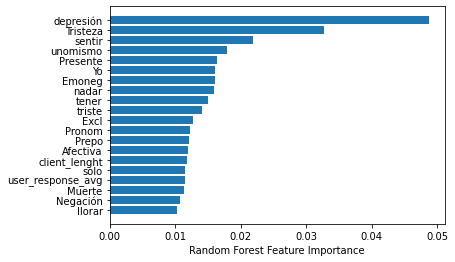

In [ ]:
# Importance Depresiva
from matplotlib import pyplot as plt



scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_merged.iloc[:,1:-1])

rf = RandomForestClassifier(max_depth=10, max_features=15).fit(data_scaled, df_merged.iloc[:,[-1]])



sorted_idx = rf.feature_importances_.argsort()[-20:]
plt.barh(df_merged.iloc[:,1:-1].columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Text(0.5, 0, 'Random Forest Feature Importance')

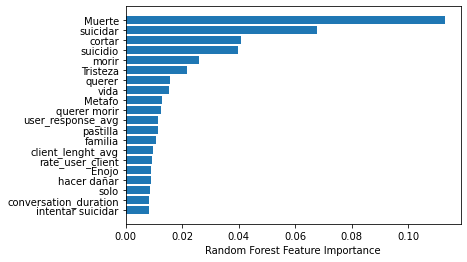

In [ ]:
# Importance Suicida
from matplotlib import pyplot as plt

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_merged.iloc[:,1:-1])

rf = RandomForestClassifier(max_depth=10, ).fit(data_scaled, df_merged.iloc[:,[-1]])



sorted_idx = rf.feature_importances_.argsort()[-20:]
plt.barh(df_merged.iloc[:,1:-1].columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
df_merged.iloc[:,1:-1].columns[[ 73,  72,  70,  20,  43,   1, 165,  47,   0, 160,  63, 152,  36,
        15,  66]]

Index(['NO_MENTAL', 'PRON_BODY_PART_BEHAVIOURAL', 'PRON_MENTAL_SENTIMENT',
       'Arriba', 'Nonfl', 'estallido', 'óseo', 'Asearse', 'pandemia', 'trans',
       'Relig', 'solo querer morir', 'Fillers', 'TV', 'Deportes'],
      dtype='object')